Librerias genericas

In [4]:
import numpy as np
from scipy import optimize as opt

import os
print(os.getcwd())

c:\Users\pablo\Documents\GitHub\Trabajo-MNP


Nuestra libreria

In [5]:
from src import Airplane

Creacion del objeto de la aeronave

In [7]:
pedro = Airplane(1000, 15)

In [11]:
print(pedro.lift_poli([1, 1]))

0.3926990816986305


Aqui se optimizan los coeficientes del polinomio

In [12]:
grado = 2

lift_target = 1000 * 9.81 # N


def objective(a):
    return abs(pedro.moment_poli(a))

ineq = opt.NonlinearConstraint(lambda a: pedro.lift_poli(a), lift_target*0.9, lift_target*1.1)


a0 = np.zeros(grado)
print(f"Coeficientes inciales: {a0}")
print("-------------------------")

res = opt.minimize(objective, a0, method='SLSQP', constraints=[ineq], options={'disp': True})

res = res.x
print("-------------------------")
print(f"Coeficientes finales: {res}")


Coeficientes inciales: [0. 0.]
-------------------------
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9.346915682905256e-10
            Iterations: 18
            Function evaluations: 73
            Gradient evaluations: 18
-------------------------
Coeficientes finales: [-22490.61796451  22490.61796451]


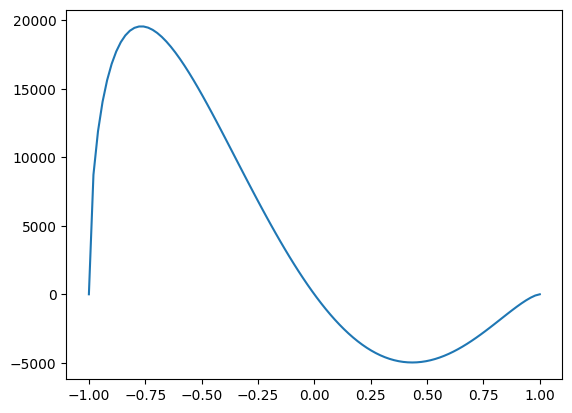

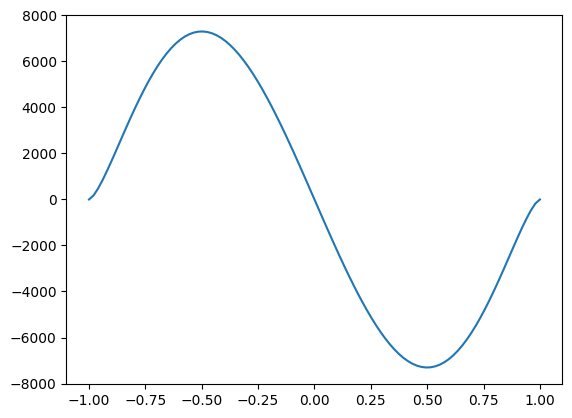

Lift total obtenido: 8832.045021471899
Momento en la raiz: -9.346915682905256e-10


In [13]:
a = [1,2,3,4]
pedro.plot_lift(res)
pedro.plot_moment(res)
print(f"Lift total obtenido: {pedro.lift_poli(res)}")
print(f"Momento en la raiz: {pedro.moment_poli(res)}")

Ejemplo de como se llama a una funcion de fortran para calcular los nodos de chebyshev

In [12]:
from src import chebyshev_nodes
from time import time
import numpy as np
import math

In [13]:
ejecuciones = 6000000

In [14]:
t0 = time()
chebyshev_nodes(ejecuciones)
print("Tiempo de ejecución: ", time()-t0)

Tiempo de ejecución:  0.20910930633544922


Aqui se ve que usando operaciones vectoriales es muchisimo mas rapido, que es lo que se deberia utilizar en fortran

In [22]:
def chebyshev_nodes(n):
    """
    Cálculo de los nodos y pesos de Chebyshev.
    
    :param n: número de nodos
    :return: (x, w) tupla de dos arrays de longitud n
             x -> nodos de Chebyshev
             w -> pesos (constantes en este caso)
    """
    # Generamos un array con valores i = 1, 2, ..., n
    i = np.arange(1, n + 1)

    # Cálculo de los nodos x(i) = cos( (2*i - 1)*pi / (2*n) )
    x = np.cos((2.0 * i - 1.0) * np.pi / (2.0 * n))

    # Cálculo de los pesos w(i) = pi / n (constante)
    w = np.full(n, np.pi / n)  # Crea un array de tamaño n con el mismo valor

    return x, w

# Ejemplo de uso
if __name__ == "__main__":
    t0 = time()
    x, w = chebyshev_nodes(ejecuciones)
    print("Tiempo de ejecución: ", time()-t0)



Tiempo de ejecución:  0.07134032249450684


Usando un bucle de Python y la libreria math (hecha en C), se ve que es extremadamente lento

In [10]:


def chebyshev_nodes(n):
    """
    Cálculo de los nodos y pesos de Chebyshev (versión sin NumPy).
    
    :param n: número de nodos
    :return: (x, w) tupla de dos listas de longitud n
             x -> nodos de Chebyshev
             w -> pesos (constantes en este caso)
    """
    x = []
    w = []
    
    for i in range(1, n + 1):
        # x(i) = cos((2*i - 1)*pi / (2*n))
        x_val = math.cos((2.0 * i - 1.0) * math.pi / (2.0 * n))
        x.append(x_val)
        
        # w(i) = pi / n
        w_val = math.pi / n
        w.append(w_val)
    
    return x, w

# Ejemplo de uso
if __name__ == "__main__":
    t0 = time()
    x, w = chebyshev_nodes(ejecuciones)
    print("Tiempo de ejecución: ", time()-t0)


Tiempo de ejecución:  0.7969439029693604
